Table of Contents:

Step 1:Import Data

Step 2: Address any PII Data

Step 3A: Create a regional segmentation of the data

Step 3B: Determine whether there’s a difference in spending habits between the different U.S. regions

Step 4: Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data

Steps 5 and 6: Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents with   
                  visualizations
               
Step 7: Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure

Step 8: Compare your customer profiles with regions and departments

In [27]:
# Importing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Step 1: Import Dataset

In [2]:
# Create a path
path = r"C:\Users\Emily\01-2026 Instacart Basket Analysis"

In [3]:
# Importing dataset from task 4.9
df = pd.read_pickle(os.path.join(path, "02 Data", "Prepared Data", "ords_prods_cust_merged_4.9.pkl"))

In [4]:
# Checking dataframe
df.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,order_frequency_flag,First Name,Last Name,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,Frequent customer,Charles,Cox,Male,Minnesota,81,8/1/2019,1,married,49620
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,Frequent customer,Charles,Cox,Male,Minnesota,81,8/1/2019,1,married,49620
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,Frequent customer,Deborah,Glass,Female,Vermont,66,6/16/2018,2,married,158302
3,1,Chocolate Sandwich Cookies,61,19,5.8,12198,652770,764,1,3,...,Frequent customer,Heather,Myers,Female,Wisconsin,40,2/9/2020,3,married,31308
4,1,Chocolate Sandwich Cookies,61,19,5.8,12200,1813452,764,3,4,...,Frequent customer,Heather,Myers,Female,Wisconsin,40,2/9/2020,3,married,31308


Step 2: Address any PII data

In [5]:
# Checking columns for any PII data
df.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'prices',
       'Unnamed: 0', 'order_id', 'user_id', 'order_number',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'add_to_cart_order', 'reordered', '_merge', 'price_range_loc',
       'busiest_day', 'busiest_days', 'busiest_period_of_day', 'max_order',
       'loyalty_flag', 'avg_product_price', 'spending_flag',
       'median_days_between_orders', 'order_frequency_flag', 'First Name',
       'Last Name', 'Gender', 'State', 'Age', 'Date Joined',
       'Number of Dependants', 'Marital Status', 'Income'],
      dtype='object')

There are many columns with sensitive information. Columns 'First Name' and 'Last Name' pose the most risk. They will need to be dropped

In [6]:
# Dropping columns that contain PII (Names will not be used going forward and the original dataframe will be overwritten.)
df.drop(columns = ['First Name', 'Last Name'], axis = 1, inplace = True)

In [7]:
# Checking columns were removed
df.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'prices',
       'Unnamed: 0', 'order_id', 'user_id', 'order_number',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'add_to_cart_order', 'reordered', '_merge', 'price_range_loc',
       'busiest_day', 'busiest_days', 'busiest_period_of_day', 'max_order',
       'loyalty_flag', 'avg_product_price', 'spending_flag',
       'median_days_between_orders', 'order_frequency_flag', 'Gender', 'State',
       'Age', 'Date Joined', 'Number of Dependants', 'Marital Status',
       'Income'],
      dtype='object')

In [8]:
# Checking shape
df.shape

(1000000, 32)

Preparing data for analysis

In [9]:
# Importing wrangled departments data

df_dept = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data','departments_wrangled.csv' ), index_col = False)

# Checking dataframe. 
df_dept.head()

,Unnamed: 0,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
# Renaming the first column (should be the department id)

df_dept.rename(columns = {'Unnamed: 0' : 'department_id'}, inplace = True)

# Checking updated dataframe
df_dept

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [11]:
# Connecting the department data with updated dataframe

# Making the department data a dictionary
zipped = zip(df_dept['department_id'], df_dept['department'])
data_dict = dict(zipped)

In [12]:
# Checking dictionary
data_dict

{1: 'frozen',
 2: 'other',
 3: 'bakery',
 4: 'produce',
 5: 'alcohol',
 6: 'international',
 7: 'beverages',
 8: 'pets',
 9: 'dry goods pasta',
 10: 'bulk',
 11: 'personal care',
 12: 'meat seafood',
 13: 'pantry',
 14: 'breakfast',
 15: 'canned goods',
 16: 'dairy eggs',
 17: 'household',
 18: 'babies',
 19: 'snacks',
 20: 'deli',
 21: 'missing'}

In [13]:
# Making a new 'department' column to show names of departments
df['department'] = df['department_id'].map(data_dict)

In [14]:
# Checking updated dataframe
df.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,median_days_between_orders,order_frequency_flag,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income,department
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,6.5,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,snacks
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,6.5,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,snacks
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,7.0,Frequent customer,Female,Vermont,66,6/16/2018,2,married,158302,snacks
3,1,Chocolate Sandwich Cookies,61,19,5.8,12198,652770,764,1,3,...,9.0,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks
4,1,Chocolate Sandwich Cookies,61,19,5.8,12200,1813452,764,3,4,...,9.0,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks


In [15]:
# Checking shape of updated dataframe
df.shape

(1000000, 33)

Step 3A: Create a regional segmentation of the data

In [16]:
#creating a region column based on state column
northeast = ["Connecticut", "Maine", "Massachusetts", "New Hampshire", 
             "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"]
midwest = ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin", 
           "Iowa", "Kansas", "Minnesota", "Missouri", 
           "Nebraska", "North Dakota", "South Dakota"]
south = ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", 
         "Virginia", "District of Columbia", "West Virginia", "Alabama", "Kentucky", 
         "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas"]
west = ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", 
        "Utah", "Wyoming", "Alaska", "California", "Hawaii", "Oregon", "Washington"]

In [17]:
# Assign states to region 
def region(state):
    if state in northeast:
        return "Northeast"
    elif state in midwest:
        return "Midwest"
    elif state in south:
        return "South"
    elif state in west:
        return "West"
    else:
        return "Unknown"

In [18]:
# Creating a region column
df["Region"] = df["State"].apply(region)

In [19]:
# Checking region cloumn
df["Region"].value_counts()

Region
South        333337
West         255990
Midwest      233768
Northeast    176905
Name: count, dtype: int64

In [20]:
# Checking output
df.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,order_frequency_flag,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income,department,Region
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,snacks,Midwest
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,snacks,Midwest
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,Frequent customer,Female,Vermont,66,6/16/2018,2,married,158302,snacks,Northeast
3,1,Chocolate Sandwich Cookies,61,19,5.8,12198,652770,764,1,3,...,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks,Midwest
4,1,Chocolate Sandwich Cookies,61,19,5.8,12200,1813452,764,3,4,...,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks,Midwest


Step 3B: Determine whether there’s a difference in spending habits between the different U.S. regions

In [21]:
# Creating a crosstab of the 'region' column with the 'spending_flag' column
crosstab_regional_spending = pd.crosstab(df['Region'], df['spending_flag'], dropna = False)

In [22]:
# Checking the crosstab
crosstab_regional_spending

spending_flag,High spender,Low spender
Region,,
Midwest,45824,187944
Northeast,34605,142300
South,64044,269293
West,50021,205969


There is a difference in spending habits between the different U.S. regions. The South stands out as having more high spenders. The Midwest and Northeast have similar spending habits. While the West is in the middle. Overall there are more low spenders than there are high spenders.

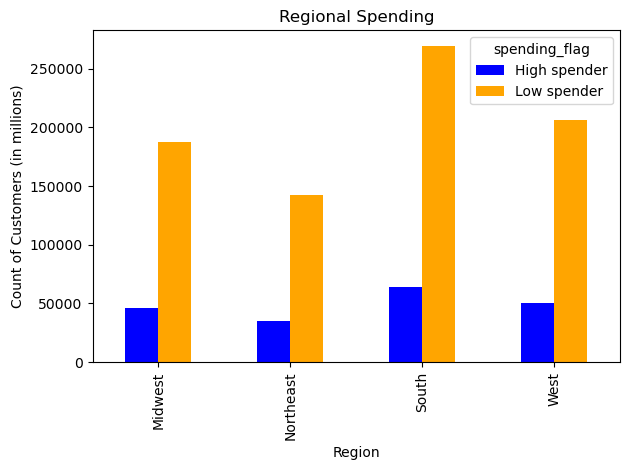

In [32]:
# Creating a bar chart to visualize crosstab
bar_reg_spending = crosstab_regional_spending.plot(kind="bar", color = ['blue', 'orange'] )

plt.title ('Regional Spending')
plt.xlabel ('Region')
plt.ylabel ('Count of Customers (in millions)')
plt.tight_layout()

In all of the regions, most customers are considered low spenders with a low frequency of high spending customers. All of the regions follow this behavior, meaning there is no unique difference in spending habits between the regions.

In [70]:
# Exporting bar chart
bar_reg_spending.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_regional_spending.png'), bbox_inches='tight')

Step 4: Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data

In [71]:
# Creating a new exclusion flag column
df.loc[df['max_order'] < 5, 'customer_activity'] = 'low'
df.loc[df['max_order'] >= 5, 'customer_activity'] = 'high'

In [72]:
# Checking flag count
df['customer_activity'].value_counts(dropna = False)

customer_activity
high    921270
low      78730
Name: count, dtype: int64

In [73]:
# Creating a new dataframe of only the low-activity customers
df_low_act_cust = df[df['customer_activity']=='low']

In [74]:
# Checking the output
df_low_act_cust.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income,department,Region,customer_activity
3,1,Chocolate Sandwich Cookies,61,19,5.8,12198,652770,764,1,3,...,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks,Midwest,low
4,1,Chocolate Sandwich Cookies,61,19,5.8,12200,1813452,764,3,4,...,Female,Wisconsin,40,2/9/2020,3,married,31308,snacks,Midwest,low
6,1,Chocolate Sandwich Cookies,61,19,5.8,13096,1871483,825,3,2,...,Male,District of Columbia,20,5/8/2019,3,living with parents and siblings,34171,snacks,South,low
34,1,Chocolate Sandwich Cookies,61,19,5.8,25854,2434812,1598,1,2,...,Male,Kansas,41,1/7/2018,2,married,122060,snacks,Midwest,low
35,1,Chocolate Sandwich Cookies,61,19,5.8,25855,1531889,1598,2,2,...,Male,Kansas,41,1/7/2018,2,married,122060,snacks,Midwest,low


In [75]:
# Checking the shape
df_low_act_cust.shape

(78730, 35)

In [76]:
# Exporting new dataframe
df_low_act_cust.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'low_activity_customers.pkl'))

In [77]:
# Checking dataframe before excluding low-activity customers 
df.shape

(1000000, 35)

In [78]:
# Creating new dataframe with only high-activity customers
df_2 = df[df['customer_activity']== 'high']

In [79]:
# Checking the shape
df_2.shape

(921270, 35)

In [80]:
# Checking the output
df_2.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income,department,Region,customer_activity
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,Male,Minnesota,81,8/1/2019,1,married,49620,snacks,Midwest,high
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,Male,Minnesota,81,8/1/2019,1,married,49620,snacks,Midwest,high
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,Female,Vermont,66,6/16/2018,2,married,158302,snacks,Northeast,high
5,1,Chocolate Sandwich Cookies,61,19,5.8,12372,1701441,777,16,1,...,Female,Hawaii,51,1/4/2019,2,married,57797,snacks,West,high
7,1,Chocolate Sandwich Cookies,61,19,5.8,14603,1290456,910,12,3,...,Female,Tennessee,65,7/25/2019,0,divorced/widowed,44856,snacks,South,high


Steps 5 and 6: Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents with visualizations

In [81]:
# Exporting updated dataframe as a pickle
df_2.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'active_cust_and_dept.pkl'))

In [82]:
# Finding which departments are most popular
df_2['department'].value_counts()

department
dairy eggs         207999
produce            113414
frozen              97930
beverages           94499
snacks              73068
pantry              63164
canned goods        60433
household           40488
breakfast           29731
dry goods pasta     28616
deli                21260
babies              18736
personal care       14580
bakery              14578
meat seafood        13436
international       11963
alcohol              8176
pets                 4927
bulk                 2489
missing              1126
other                 657
Name: count, dtype: int64

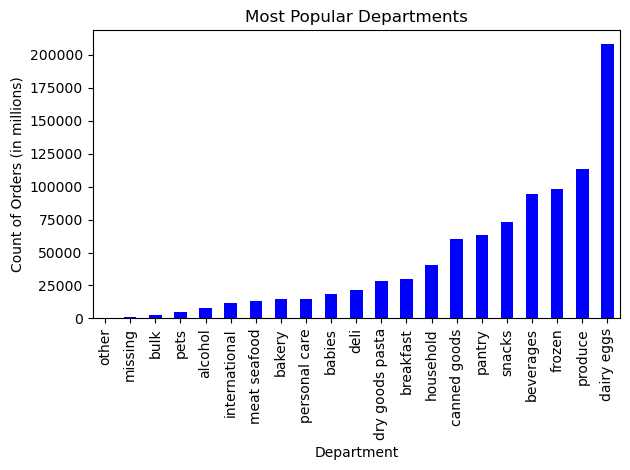

In [83]:
# Bar chart of departments by order count
bar_pop_dept = df_2['department'].value_counts().sort_values().plot(kind = 'bar', color = ['Blue'])

plt.title('Most Popular Departments')
plt.xlabel('Department')
plt.ylabel('Count of Orders (in millions)')

plt.tight_layout()

Dairy/Eggs is the most popular department. Produce is the second most ordered and Frozen and Beverages also have very high order counts.

In [84]:
# Exporting bar chart. 
bar_pop_dept.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'bar_pop_dept.png'))

In [85]:
# Finding which produce items are the most popular
df_produce_only = df_2[df_2['department'] == 'produce']

In [86]:
# Checking output
df_produce_only.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,Gender,State,Age,Date Joined,Number of Dependants,Marital Status,Income,department,Region,customer_activity
10881,31,White Pearl Onions,123,4,7.5,47524,2766690,2937,3,1,...,Male,Ohio,28,5/25/2018,3,married,88405,produce,Midwest,high
10882,31,White Pearl Onions,123,4,7.5,74568,2960023,4582,2,2,...,Male,Tennessee,24,8/1/2019,1,married,64749,produce,South,high
10883,31,White Pearl Onions,123,4,7.5,74579,987065,4582,13,6,...,Male,Tennessee,24,8/1/2019,1,married,64749,produce,South,high
10884,31,White Pearl Onions,123,4,7.5,77092,1062850,4705,65,4,...,Female,Idaho,65,6/26/2017,0,divorced/widowed,63568,produce,West,high
10885,31,White Pearl Onions,123,4,7.5,143895,741886,8662,14,3,...,Female,Tennessee,62,3/7/2017,2,married,87777,produce,South,high


In [87]:
# Count of products to find the most popular. Retrieving only the top 10 items
top_produce_items = df_produce_only['product_name'].value_counts().head(10)

In [88]:
# Top 10 produce items
top_produce_items

product_name
Cantaloupe                                    22601
European Cucumber                             17139
Organic Fresh Basil                           11195
Organic Orange Bell Pepper                     9878
Parsley, Italian (Flat), New England Grown     7784
Mini Cucumbers                                 7185
Garnet Sweet Potato (Yam)                      6186
Organic Peeled & Cooked Beets                  5119
Nectarines                                     4575
Mini Watermelon                                3199
Name: count, dtype: int64

The most ordered items are cantaloupe, european cucumber, and fresh basil with mni watermelon and nectarines being the least.

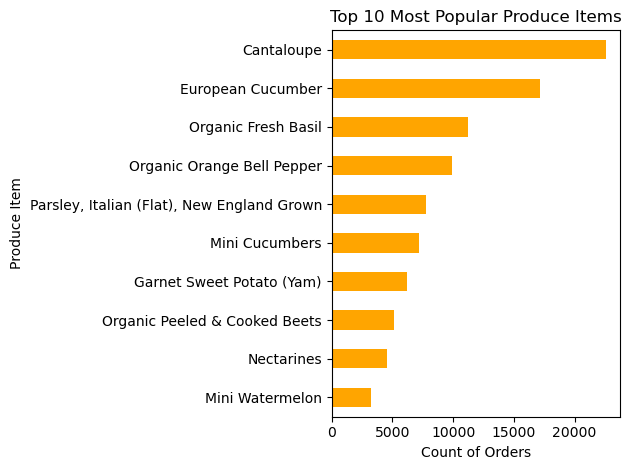

In [89]:
# Bar chart of the top 10 most popular produce items
bar_top_produce = top_produce_items.sort_values().plot(kind='barh', color='orange')

plt.title('Top 10 Most Popular Produce Items')
plt.xlabel('Count of Orders')
plt.ylabel('Produce Item')

plt.tight_layout()

In [90]:
# Exporting bar chart
bar_top_produce.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_top_produce.png'))

In [91]:
# Finding distribution of price range groupings 
df_2['price_range_loc'].value_counts(dropna = False)

price_range_loc
Mid-range product     601975
Low-range product     311021
High-range product      8274
Name: count, dtype: int64

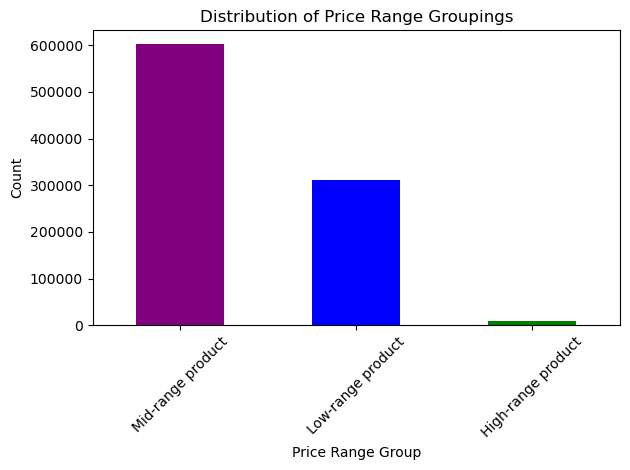

In [92]:
# Bar chart of price range groupings
bar_price_range = df_2['price_range_loc'].value_counts().plot.bar(color = ['purple', 'blue', 'green'])
                                                                                 
plt.title('Distribution of Price Range Groupings')
plt.xlabel('Price Range Group')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.tight_layout()

Most items are considered a mid-range product meaning their price is between 5 to 15 dollars.

In [93]:
# Exporting bar chart
bar_price_range.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_price_range_dist.png'), bbox_inches='tight')

Text(0, 0.5, '')

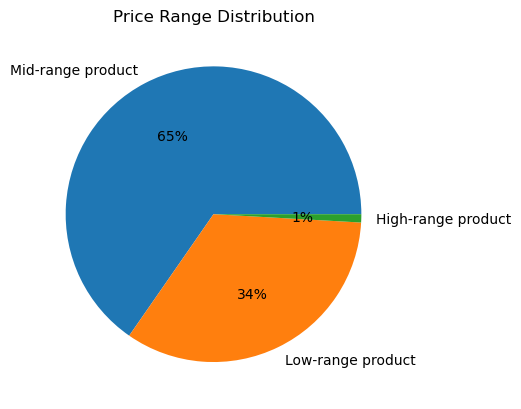

In [94]:
# Pie chart for price range groupings 
pie_1 = df_2['price_range_loc'].value_counts().plot.pie(autopct=('%1.f%%'), title='Price Range Distribution')
plt.ylabel('')  

In [95]:
# Exporting pie chart
pie_1.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'pie_price_groups.png'),bbox_inches='tight')

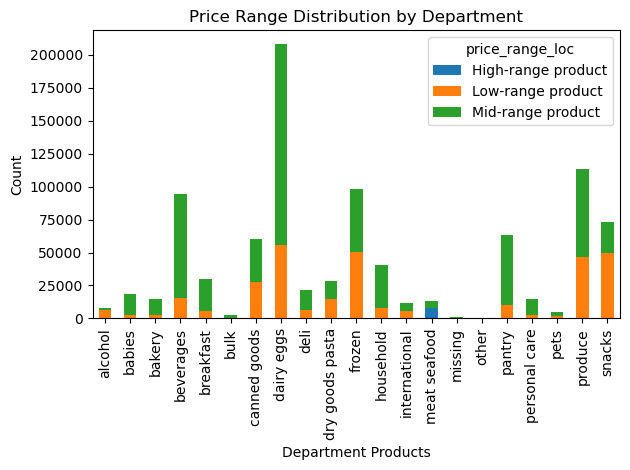

In [96]:
# Stacked bar chart of price ranges and department products to see how prices differ from one another
crosstab_price_group_dept = pd.crosstab(df_2['department'], df_2['price_range_loc']).plot(kind='bar', stacked=True)

plt.title('Price Range Distribution by Department')
plt.xlabel('Department Products')
plt.ylabel('Count')

plt.tight_layout()

In [97]:
# Exporting stacked bar chart
crosstab_price_group_dept.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'stckbar_price_dept.png'), bbox_inches='tight')

In [98]:
# Checking statistics of age column
df_2['Age'].describe()

count    921270.000000
mean         49.484424
std          18.508229
min          18.000000
25%          33.000000
50%          49.000000
75%          65.000000
max          81.000000
Name: Age, dtype: float64

The average age is about 49 years old. The minimum age is 18 years old. The maximumu age is 81 years old.

In [99]:
# Grouping ages into categories

# Young Adults
df_2.loc[df_2['Age'] <= 33, 'age_category'] = 'Young Adult'

# Middle-aged' Adults.
df_2.loc[(df_2['Age'] > 33) & ( df_2 ['Age'] < 65), 'age_category'] = 'Middle-aged Adult'

# Older Adults
df_2.loc[df_2['Age'] >= 65, 'age_category'] = 'Senior'

C:\Users\Emily\AppData\Local\Temp\ipykernel_8108\2611183234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[df_2['Age'] <= 33, 'age_category'] = 'Young Adult'


In [100]:
# Checking results
df_2['age_category'].value_counts(dropna = False)

age_category
Middle-aged Adult    446411
Senior               243672
Young Adult          231187
Name: count, dtype: int64

Yound Adults= 18 to 33, Middle-aged Adults= 33 to 65 , Older Adults= 65+

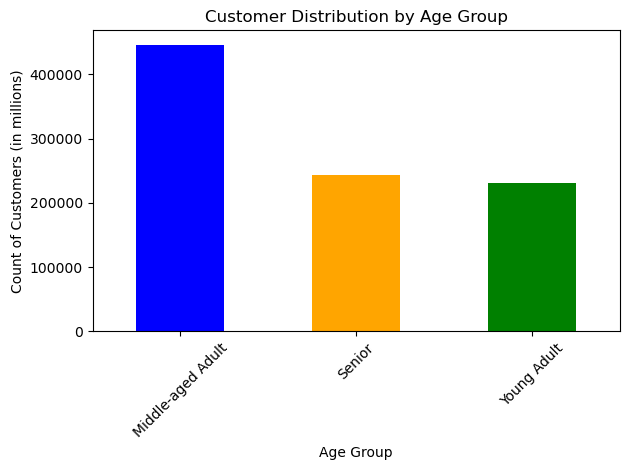

In [101]:
# Bar chart of customers by age group
bar_cust_age = df_2['age_category'].value_counts().plot(kind = 'bar', color = ['blue', 'orange', 'green'])

plt.title('Customer Distribution by Age Group')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.ylabel('Count of Customers (in millions)')

plt.tight_layout()

Most customers are middle aged.

In [122]:
# Checking statistics of family variables
df_2[['Income', 'Number of Dependants', 'Age']].agg(['min', 'max', 'mean'])

,Income,Number of Dependants,Age
min,25911.000000,0.000000,18.000000
max,593901.000000,3.000000,81.000000
mean,99989.377622,1.500185,49.484424


In [127]:
# Crosstab of age and family status
crosstab_age_fam_status = pd.crosstab(df_2['Marital Status'], df_2['age_category'], dropna = False)
crosstab_age_fam_status

age_category,Middle-aged Adult,Senior,Young Adult
Marital Status,,,
divorced/widowed,18330,60287,0
living with parents and siblings,0,0,44750
married,333350,183385,128467
single,94731,0,57970


Most of the customers are middle-aged and married.

In [129]:
# Creating profiles (family vs. single)

# Define conditions
conditions = [
    (df_2['Age'] <= 33) & (df_2['Number of Dependants'] == 0),
    (df_2['Age'] <= 33) & (df_2['Number of Dependants'] >= 1),
    (df_2['Age'] >= 34) & (df_2['Age'] <= 65) & (df_2['Number of Dependants'] == 0),
    (df_2['Age'] >= 34) & (df_2['Age'] <= 65) & (df_2['Number of Dependants'] >= 1),
    (df_2['Age'] > 65) & (df_2['Number of Dependants'] == 0),
    (df_2['Age'] > 65) & (df_2['Number of Dependants'] >= 1)
]

# Define corresponding outputs
choices = [
    'Young single',
    'Young family',
    'Older single',
    'Older family',
    'Senior alone',
    'Senior family'
]

In [131]:
# Apply the profile
df_2['household_status'] = np.select(conditions, choices, default='Other')

C:\Users\Emily\AppData\Local\Temp\ipykernel_8108\2809110973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['household_status'] = np.select(conditions, choices, default='Other')


In [132]:
# Checking output
df_2.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,Age,Date Joined,Number of Dependants,Marital Status,Income,department,Region,customer_activity,age_category,household_status
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,81,8/1/2019,1,married,49620,snacks,Midwest,high,Senior,Senior family
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,81,8/1/2019,1,married,49620,snacks,Midwest,high,Senior,Senior family
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,66,6/16/2018,2,married,158302,snacks,Northeast,high,Senior,Senior family
5,1,Chocolate Sandwich Cookies,61,19,5.8,12372,1701441,777,16,1,...,51,1/4/2019,2,married,57797,snacks,West,high,Middle-aged Adult,Older family
7,1,Chocolate Sandwich Cookies,61,19,5.8,14603,1290456,910,12,3,...,65,7/25/2019,0,divorced/widowed,44856,snacks,South,high,Senior,Older single


In [133]:
# Creating crosstab fo household_status and department
crosstab_fam_department = pd.crosstab(df_2['department'], df_2['household_status'])

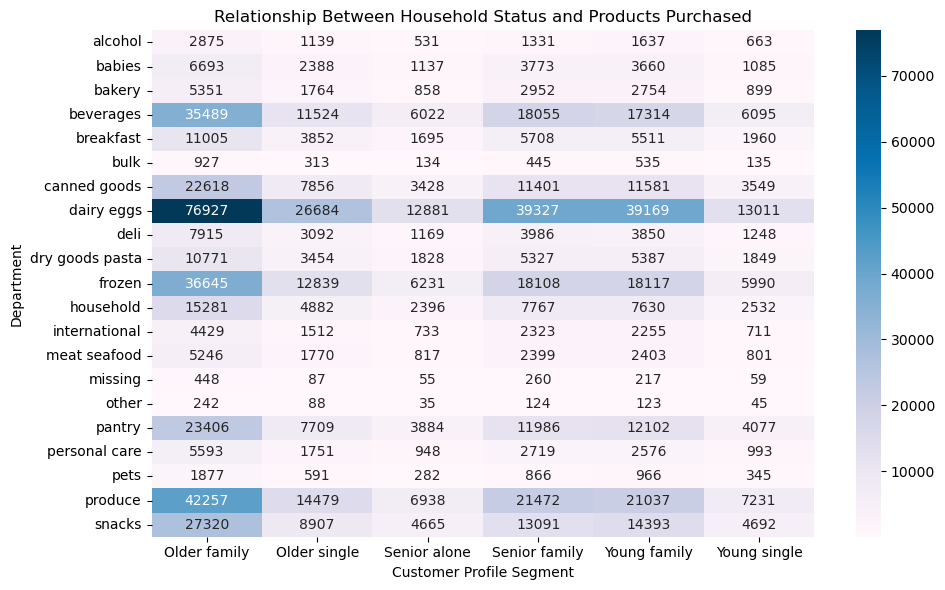

In [155]:
# Creating heatmap
plt.figure(figsize=(10, 6))
                             
sns.heatmap(crosstab_fam_department, cmap='PuBu', annot=True,fmt='d')
                                    
                                      
# Labels
plt.title('Relationship Between Household Status and Products Purchased')
plt.ylabel('Department')
plt.xlabel('Customer Profile Segment')
                                     
plt.tight_layout()

# Exporting heatmap
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'heatmap_household_dept.png'), bbox_inches='tight')

The heatmap shows that seniors and young singles have similar ordering patterns. Families also buy similar items, mainly produce and dairy, while older familes purchase more items overall, especially snacks and beverages. 

In [137]:
# Checking Income variable
df_2['Income'].describe()

count    921270.000000
mean      99989.377622
std       44934.372047
min       25911.000000
25%       66981.000000
50%       96753.000000
75%      128375.000000
max      593901.000000
Name: Income, dtype: float64

In [138]:
# Creating income profiles
df_2.loc[df_2['Income'] <30000, 'income_category'] = 'Low Income'
df_2.loc[(df_2['Income'] >30000) & (df_2['Income'] <= 99000), 'income_category'] = 'Average Income'
df_2.loc[df_2['Income'] > 99000, 'income_category'] = 'High Income'

C:\Users\Emily\AppData\Local\Temp\ipykernel_8108\4029786812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[df_2['Income'] <30000, 'income_category'] = 'Low Income'


In [139]:
# Checking output with new income category column
df_2.head()

,product_id,product_name,aisle_id,department_id,prices,Unnamed: 0,order_id,user_id,order_number,orders_day_of_week,...,Date Joined,Number of Dependants,Marital Status,Income,department,Region,customer_activity,age_category,household_status,income_category
0,1,Chocolate Sandwich Cookies,61,19,5.8,1987,3139998,138,28,6,...,8/1/2019,1,married,49620,snacks,Midwest,high,Senior,Senior family,Average Income
1,1,Chocolate Sandwich Cookies,61,19,5.8,1989,1977647,138,30,6,...,8/1/2019,1,married,49620,snacks,Midwest,high,Senior,Senior family,Average Income
2,1,Chocolate Sandwich Cookies,61,19,5.8,11433,389851,709,2,0,...,6/16/2018,2,married,158302,snacks,Northeast,high,Senior,Senior family,High Income
5,1,Chocolate Sandwich Cookies,61,19,5.8,12372,1701441,777,16,1,...,1/4/2019,2,married,57797,snacks,West,high,Middle-aged Adult,Older family,Average Income
7,1,Chocolate Sandwich Cookies,61,19,5.8,14603,1290456,910,12,3,...,7/25/2019,0,divorced/widowed,44856,snacks,South,high,Senior,Older single,Average Income


In [140]:
# Checking distribution of income categories
df_2['income_category'].value_counts()

income_category
Average Income    479873
High Income       435146
Low Income          6248
Name: count, dtype: int64

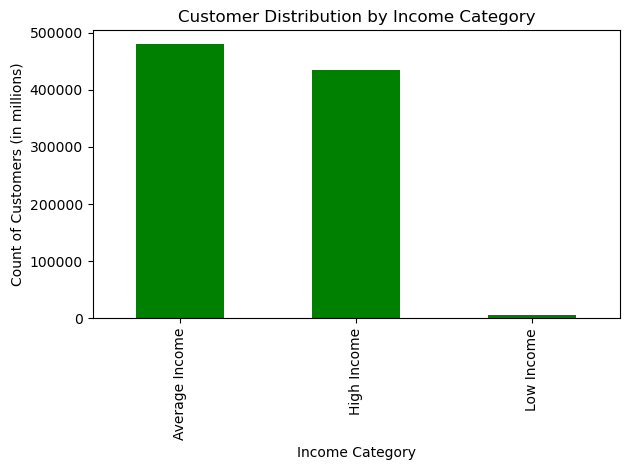

In [141]:
# Creating bar chart
bar_income_dist = df_2['income_category'].value_counts().plot.bar(color = 'green')


plt.title('Customer Distribution by Income Category')
plt.xlabel('Income Category')
plt.ylabel('Count of Customers (in millions)')

plt.tight_layout()

Most customers fall into the average-income group, followed closely by high-income customers. Only a very small portion of customers are in the low-income category.

In [142]:
# Exporting chart
bar_income_dist.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_cust_income_dist.png'),bbox_inches='tight')

Step 7: Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure

In [143]:
# Aggregate max, mean, min by age category (usage frequency + expenditure)
# Usage frequency (orders per customer)
cust_profile_agg = (df_2
    .groupby("age_category")
    .agg(
        # Usage frequency (order count)
        min_order_count=("max_order", "min"),
        mean_order_count=("max_order", "mean"),
        max_order_count=("max_order", "max"),

        # Expenditure (spend)
        min_spend=("prices", "min"),
        mean_spend=("prices", "mean"),
        max_spend=("prices", "max"))
    .reset_index())

display(cust_profile_agg)

,age_category,min_order_count,mean_order_count,max_order_count,min_spend,mean_spend,max_spend
0,Middle-aged Adult,5,33.367778,99,1.0,7.752540,24.5
1,Senior,5,32.966832,99,1.0,7.712845,24.5
2,Young Adult,5,33.008400,99,1.0,7.726674,24.5


In [144]:
# Aggregating expenditure (prices)
df_2.groupby('age_category').agg({'prices': ['min', 'max', 'mean']})

prices                
                     min   max      mean
age_category                            
Middle-aged Adult    1.0  24.5  7.752540
Senior               1.0  24.5  7.712845
Young Adult          1.0  24.5  7.726674

In [145]:
# Aggregating usage frequency (median_days_between_orders)
df_2.groupby('age_category').agg({'median_days_between_orders': ['min', 'max', 'mean']})

median_days_between_orders                 
                                         min   max       mean
age_category                                                 
Middle-aged Adult                        0.0  30.0   9.993325
Senior                                   0.0  30.0  10.013270
Young Adult                              0.0  30.0  10.036079

Step 8: Compare your customer profiles with regions and departments

In [146]:
# Exporting bar chart
bar_cust_age.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'bar_cust_age_count.png'), bbox_inches='tight')

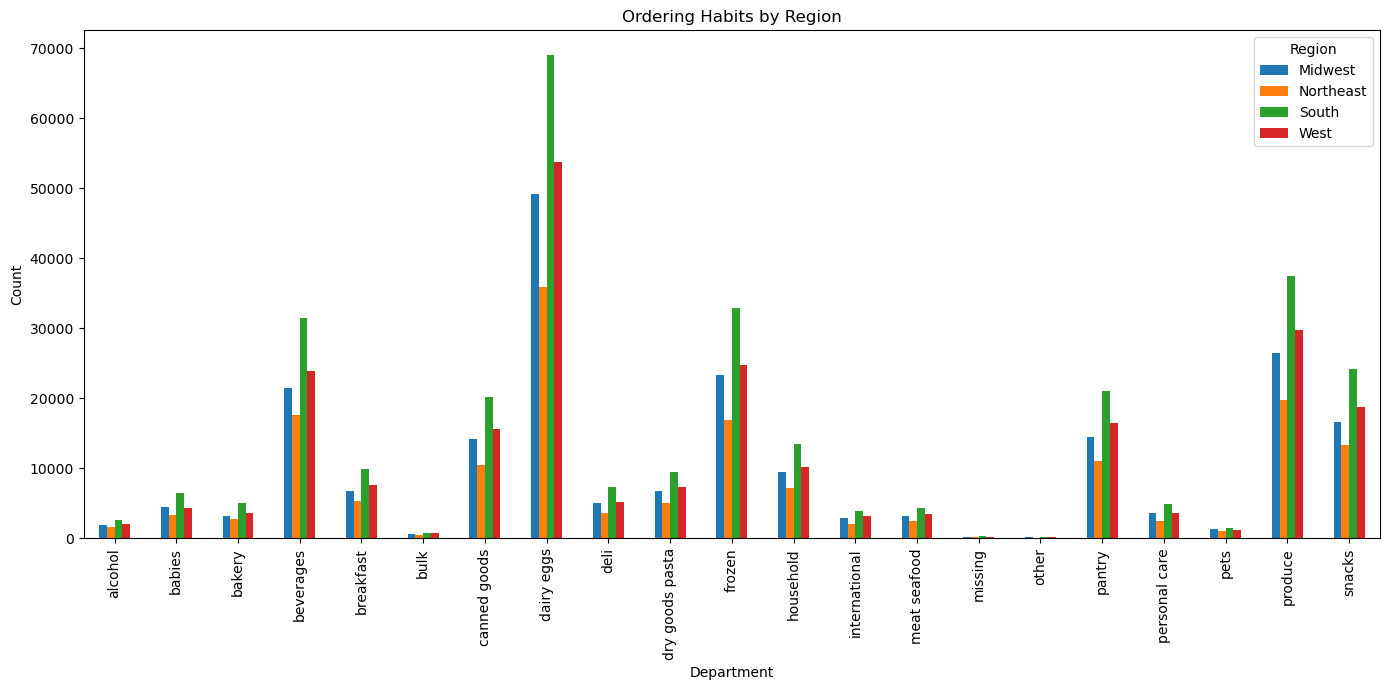

In [148]:
# Seeing what products are popular in each region 

# Crosstab 
crosstab_region_dept = pd.crosstab(df_2['department'], df_2['Region']).plot(kind='bar', stacked=False, figsize=(14,7))

plt.title('Ordering Habits by Region')
plt.xlabel('Department')
plt.ylabel('Count')
         
plt.tight_layout()

# Exporting Chart
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'bar_region_orders.png'), bbox_inches='tight')

In [149]:
# Crosstab of region and household status
crosstab_region_house = pd.crosstab(df_2['household_status'], df_2['Region'])

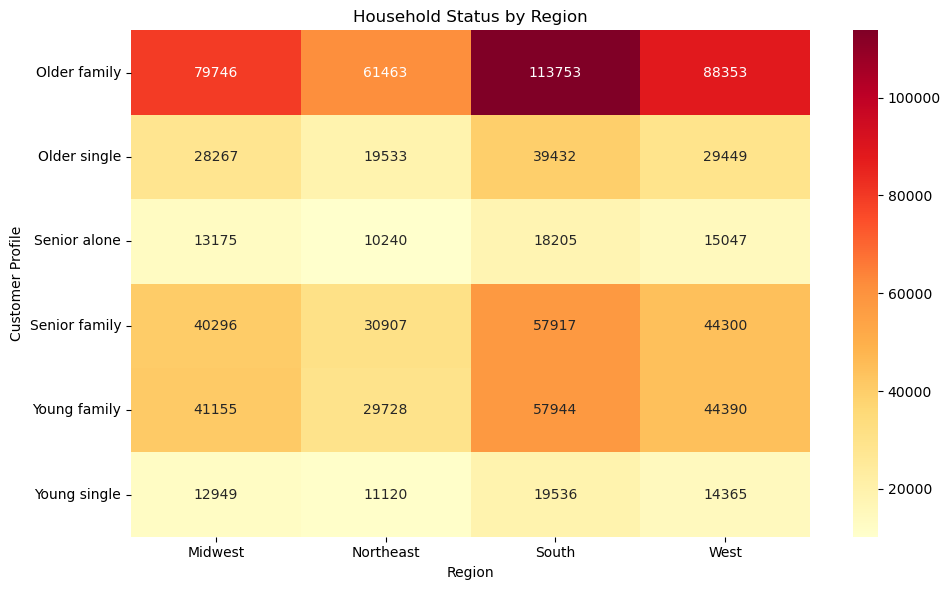

In [154]:
# Creating heatmap 
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_region_house, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Household Status by Region')
plt.xlabel('Region')
plt.ylabel('Customer Profile')
         
plt.tight_layout()

# Exporting heatmap
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'heatmap_region_household.png'), bbox_inches='tight')

In [156]:
# Crosstab region and income_category
crosstab_region_income = pd.crosstab(df_2['Region'], df_2['income_category'])

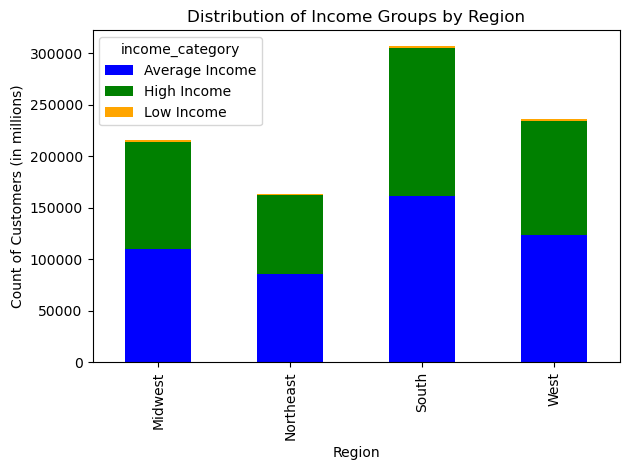

In [157]:
# Creating bar chart
bar_region_income = crosstab_region_income.plot(kind='bar', stacked =True, color = ['blue', 'green', 'orange'])

plt.title('Distribution of Income Groups by Region')
plt.xlabel('Region')
plt.ylabel('Count of Customers (in millions)')
       
plt.tight_layout()

The distribution of customers by income category is similar across all 4 regions. Most customers in each region earn average to high incomes, with few low-income customers. The Northeast has the fewest customers and could be targeted to grow app usage.

In [159]:
# Exporting chart
bar_region_income.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_region_income.png'),bbox_inches='tight')

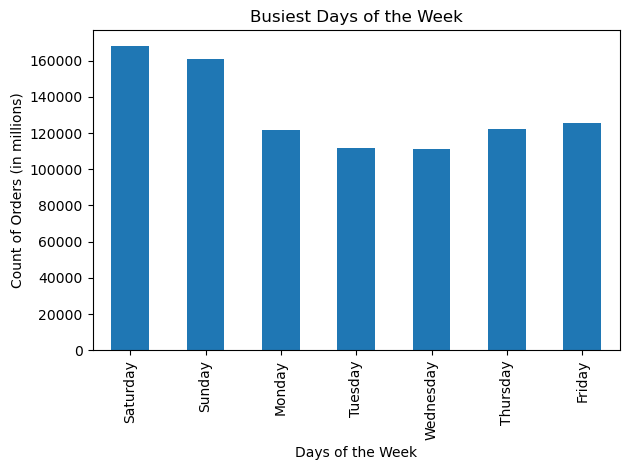

In [160]:
# Bar chart busiest day of the week
bar_orders_dow = df_2['orders_day_of_week'].value_counts().sort_index().plot.bar()

plt.title('Busiest Days of the Week')
plt.xlabel('Days of the Week')
plt.ylabel('Count of Orders (in millions)')
plt.xticks(ticks=range(7), labels=['Saturday', 'Sunday', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'])        
plt.tight_layout()

The busiest days of the week are Saturday and Sunday. Tuesday and Wednesday have the least number of orders. To boost sales, more ads could be placed during those days.

In [161]:
# Exporting chart
bar_orders_dow.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_busiest_days.png'),bbox_inches='tight')

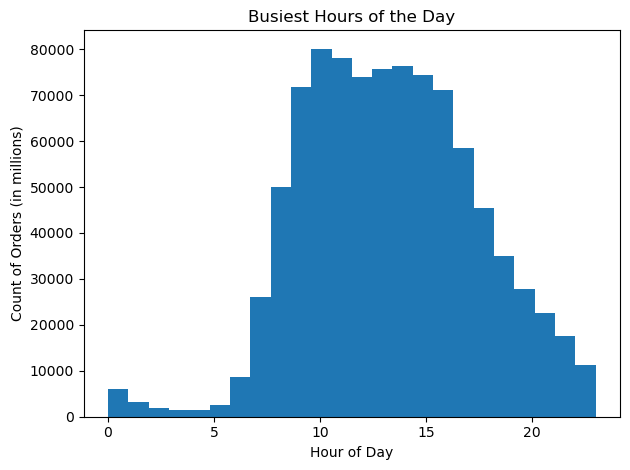

In [162]:
# Histogram busiest hours of the day
hist_busiest_hours = df_2['order_hour_of_day'].plot.hist(bins = 24)


plt.title('Busiest Hours of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Orders (in millions)')
     
plt.tight_layout()

Orders peak between 10 AM and 3 PM. The highest activity appears around late morning to early afternoon (roughly 11 AM–2 PM). Very few orders between 12 AM and 5 AM.

In [163]:
# Exporting histogram
hist_busiest_hours.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'hist_busiest_hours.png'),bbox_inches='tight')

In [164]:
# Creating a new dataframe that for 'prices' and 'order_hour_of_day' columns
df_price_sample =  df_2[['order_hour_of_day', 'prices']]
df_price_sample.head()

,order_hour_of_day,prices
0,11,5.8
1,17,5.8
2,21,5.8
5,7,5.8
7,10,5.8


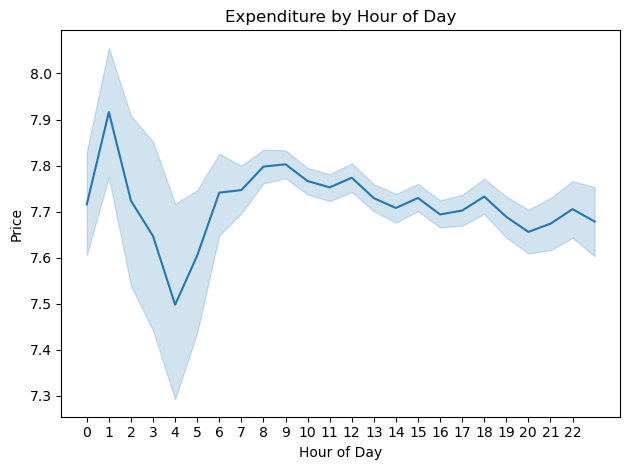

In [165]:
# Creating a line chart
line_price_hours = sns.lineplot(data = df_price_sample, x = 'order_hour_of_day', y = 'prices')

plt.title('Expenditure by Hour of Day')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 23))
plt.ylabel('Price')

plt.tight_layout()

People spend the most very early in the morning around 2–5 AM. Spending is lowest in the mid-morning around 9–10 AM.People order more expensive items early morning and evening, and cheaper items mid-morning.

In [166]:
# Exporting line chart
line_price_hours.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_price_hours.png'),bbox_inches='tight')

In [167]:
# Creating a subset
df_price_dow =  df_2[['orders_day_of_week', 'prices']]
df_price_dow.head()

,orders_day_of_week,prices
0,6,5.8
1,6,5.8
2,0,5.8
5,1,5.8
7,3,5.8


In [ ]:
# Creating line chart for prices and orders day of week
line_price_dow = sns.lineplot(data = df_price_dow, x = 'orders_day_of_week', y = 'prices')

plt.title('Expenditure During the Week')
plt.xlabel('Day of the Week')
plt.xticks(ticks=range(7), labels=['Saturday', 'Sunday', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45) 
plt.ylabel('Price')

plt.tight_layout()

Customer spending increases from Saturday to Sunday. Customers are not only ordering more on Suday, but also spending more on products. Customers spend the morst on Monday.

In [ ]:
# Exporting line chart
line_price_dow.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_price_dow.png'),bbox_inches='tight')

In [ ]:
# Pie chart of distribution of customers by loyalty status.
pie_2 =  df_2['loyalty_flag'].value_counts().plot.pie(autopct=('%1.f%%'), title='Customer Loyalty Distribution', colors=['plum','pink', 'magenta'])

 # No y-label
plt.ylabel('')  

In [ ]:
# Exporting pie chart
pie_2.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'pie_cust_loyalty.png'),bbox_inches='tight')

Step 10: Export Final Data Set

In [ ]:
# Exporting final dataframe
df_2.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'data_final_analysis.pkl'))